I found that the mutual information only change at the very beginning (about 1~2 epoch), and then the mutual information keep almost unchanged. So here I only run 2 epoch to see the trend of mutual information

Also, as the computation for mutual information is quite time-consuming, I can not calculate for all train data. I randomly sample 2000 input and calculate their average (these 2000 random sample are fixed at the begining, instead of randomly pick 2000 each time) 

In [5]:
# %load runner.py

from reader import read_dataset
from models.LeNet5 import LeNet5
from models.ResNet import ResNet
import tensorflow as tf
from glob import glob
import os
import sys
import signal
from config import get_config
from entropy import entropy
from plot import plot_info_plain
import pickle


class Runner(object):
    def __init__(self, config, model):
        self.config = config
        self.dataset = read_dataset(config.batch_size, config.valid_size,
                                    config.sample_size)
        self.graph = tf.Graph()
        self.model = None
        self.restore = False
        if not os.path.exists(self.config.model_path):
            os.mkdir(self.config.model_path)
        for key in config.__dict__:
            print(key, config.__dict__[key])
        with self.graph.as_default():
            self.model = model(self.config)

        self.IXT = []
        self.ITY = []

    def run(self):
        with self.graph.as_default(), tf.Session() as sess:
            self.restore = True
            model_path = os.path.join(self.config.model_path,
                                      self.config.model_name)
            saver = tf.train.Saver()
            files = glob(os.path.join(self.config.model_path, '*.ckpt.*'))

            if len(files) > 0:
                saver.restore(sess, model_path)
                print(('Model restored from:' + model_path))
            else:
                print("Model doesn't exist.\nInitializing........")
                sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())

            def handler_stop_signals(signum, frame):

                print(
                    'training shut down,  the model will be save in %s' % (
                        model_path))
                saver.save(sess, save_path=model_path)
                sys.exit(0)

            signal.signal(signal.SIGINT, handler_stop_signals)
            signal.signal(signal.SIGTERM, handler_stop_signals)

            total_loss = 0
            while self.dataset.epoch < 2:
                data, label = self.dataset.next_training_batch()
                _, step, loss, layers = sess.run(
                    [self.model.train_op, self.model.global_step,
                     self.model.loss, self.model.layers_collector],
                    feed_dict={self.model.input: data,
                               self.model.label: label})
                total_loss += loss

                if step % 10 == 0:
                    sample_data = self.dataset.sample_batch()
                    layers = sess.run(self.model.layers_collector,
                                      feed_dict={self.model.input: sample_data
                                                 })
                    ixt, ity = entropy(layers)
                    # print(ixt)
                    # print(ity)
                    self.IXT.append(ixt)
                    self.ITY.append(ity)
                    print(ixt,ity)

            self._test(sess)
            saver.save(sess, save_path=model_path)
            self.plot_info_plane()
            print(
                'training finished,  the model will be save in %s' % (
                    self.config.model_path))

    def test(self):
        with self.graph.as_default(), tf.Session() as sess:
            files = glob(os.path.join(self.config.model_path, '*.ckpt.*'))
            assert len(files) > 0
            saver = tf.train.Saver()
            saver.restore(sess, os.path.join(self.config.model_path,
                                             self.config.model_name))
            print(('Model restored from:' + self.config.model_path))
            self._test(sess)
            self.plot_info_plane()

    def plot_info_plane(self):
        print('flag')
        with open('ixt', 'wb') as f:
            pickle.dump(self.IXT, f)
        with open('ity', 'wb') as f:
            pickle.dump(self.ITY, f)
        plot_info_plain(self.IXT, self.ITY)

    def _test(self, sess):
        test_data, test_label = self.dataset.test_batch()
        accu = sess.run(self.model.accuracy,
                        feed_dict={self.model.input: test_data,
                                   self.model.label: test_label})
        print('test accuracy:%f' % accu)


if __name__ == '__main__':

    model = LeNet5
    if len(sys.argv) > 1:
        if sys.argv[1] == 'LeNet5':
            print("Using LetNet5")
            model = LeNet5
        elif sys.argv[1] == 'miniResNet':
            print("Using miniResNet")
            model = ResNet
    if model:
        runner = Runner(get_config(), LeNet5)
        runner.run()
    else:
        print('model not defined!')
        sys.exit(1)


l2_norm True
decay_step 1200
model_path ./trained_model/
initializer xavier
batch_size 50
l2_beta 0.01
use_lr_decay True
keep_prob 0.6
activate_func tanh
sample_size 2000
model_name latest.ckpt
valid_size 1000
batch_norm False
max_epoch 20
valid_step 1200
info_plane_interval 1200
lr_decay 0.85
learning_rate 0.0005
optimizer adam
dropout True
Model doesn't exist.
Initializing........
[ 2.4558991   0.27594817 -0.64726419] [ 0.66863778  2.84858871  3.77180108]
[ 2.45187995  0.24807246 -0.68261586] [ 0.84944046  3.05324794  3.98393627]
[ 2.43411685  0.23903768 -0.67708093] [ 0.96439031  3.15946948  4.07558808]
[ 2.44627379  0.24782367 -0.68793458] [ 0.98973848  3.1881886   4.12394684]
[ 2.43740185  0.25787018 -0.68783636] [ 1.05932445  3.23885611  4.18456265]
[ 2.43376581  0.25664124 -0.68955511] [ 1.07981359  3.25693816  4.20313451]
[ 2.42888964  0.2715946  -0.6974976 ] [ 1.04945519  3.20675023  4.17584243]
[ 2.43467404  0.26912835 -0.68658106] [ 1.18449924  3.35004493  4.30575434]
[ 2.44

[ 2.33985589  0.16886558 -0.20999604] [ 1.36079343  3.53178374  3.91064536]
[ 2.32945914  0.15678553 -0.13746183] [ 1.40946625  3.58213986  3.87638722]
[ 2.31032671  0.15963343 -0.16332556] [ 1.4339101   3.58460338  3.90756236]
[ 2.30380732  0.16261274 -0.14712046] [ 1.44728337  3.58847795  3.89821114]
[ 2.32532688  0.16250943 -0.07892753] [ 1.39362378  3.55644123  3.79787819]
[ 2.3341452   0.15689985 -0.17834364] [ 1.41683843  3.59408377  3.92932726]
[ 2.32484439  0.1535663  -0.09046125] [ 1.41106619  3.58234428  3.82637183]
[ 2.33586949  0.1530204  -0.07938645] [ 1.44175842  3.62460752  3.85701436]
[ 2.32501937  0.15461255 -0.07698977] [ 1.43416106  3.60456789  3.83617021]
[ 2.31641114  0.15442749 -0.01610948] [ 1.38437741  3.54636106  3.71689803]
[ 2.31397826  0.16495167 -0.03681641] [ 1.41371411  3.56274069  3.76450878]
[ 2.32225513  0.15485845 -0.15249506] [ 1.41651915  3.58391583  3.89126934]
[ 2.32414387  0.15707741 -0.18748076] [ 1.46058081  3.62764727  3.97220544]
[ 2.31465533

[ 2.30398564  0.10361015  0.07761501] [ 1.47501957  3.67539506  3.7013902 ]
[ 2.30201508  0.10968634  0.04363296] [ 1.44880103  3.64112978  3.70718316]
[ 2.32740555  0.09833731  0.12916726] [ 1.44367241  3.67274066  3.6419107 ]
[ 2.33097118  0.09765016  0.17326102] [ 1.43051641  3.66383744  3.58822657]
[ 2.32725779  0.10680791  0.15028133] [ 1.39817118  3.61862106  3.57514765]
[ 2.32031472  0.09735282  0.16020437] [ 1.41757495  3.64053686  3.5776853 ]
[ 2.31817305  0.09535653  0.07528497] [ 1.46951351  3.69233003  3.71240159]
[ 2.3443429   0.10074076  0.09670469] [ 1.46150471  3.70510685  3.70914293]
[ 2.32997043  0.09163319  0.25116264] [ 1.42483479  3.66317202  3.50364258]
[ 2.33583113  0.08269689  0.25625155] [ 1.41730568  3.67043992  3.49688526]
[ 2.33562427  0.08421782  0.13353399] [ 1.4595154   3.71092184  3.66160567]
[ 2.32371642  0.08356043  0.10038439] [ 1.47703522  3.71719121  3.70036724]
[ 2.31903564  0.08049737  0.16813983] [ 1.47880941  3.71734768  3.62970522]
[ 2.32326778

[ 2.3372846   0.15960462 -0.18838417] [ 1.43486366  3.61254364  3.96053242]
[ 2.32993767  0.14920781 -0.16312339] [ 1.42542245  3.60615231  3.91848351]
[ 2.33598444  0.13777759 -0.11860221] [ 1.42609514  3.62430199  3.88068179]
[ 2.32713043  0.13872729 -0.04607554] [ 1.37750634  3.56590948  3.75071231]
[ 2.32856816  0.13617643 -0.03852592] [ 1.41152035  3.60391209  3.77861443]
[ 2.32725075  0.14867255 -0.01345798] [ 1.40926855  3.58784675  3.74997728]
[ 2.33686414  0.16006659 -0.11119038] [ 1.40973481  3.58653237  3.85778933]
[ 2.34494899  0.14581424 -0.11598465] [ 1.4228826   3.62201735  3.88381624]
[ 2.33599351  0.15066358 -0.17671356] [ 1.4572861   3.64261603  3.96999317]
[ 2.34213417  0.14987701 -0.13299139] [ 1.42823088  3.62048803  3.90335643]
[ 2.34002234  0.14625233 -0.04020975] [ 1.39441438  3.58818439  3.77464647]
[ 2.33527105  0.14734175 -0.04594808] [ 1.42945239  3.61738169  3.81067152]
[ 2.32808324  0.14968334 -0.09932466] [ 1.44350816  3.62190806  3.87091606]
[ 2.3364604 

training finished,  the model will be save in ./trained_model/


In [4]:
%matplotlib inline

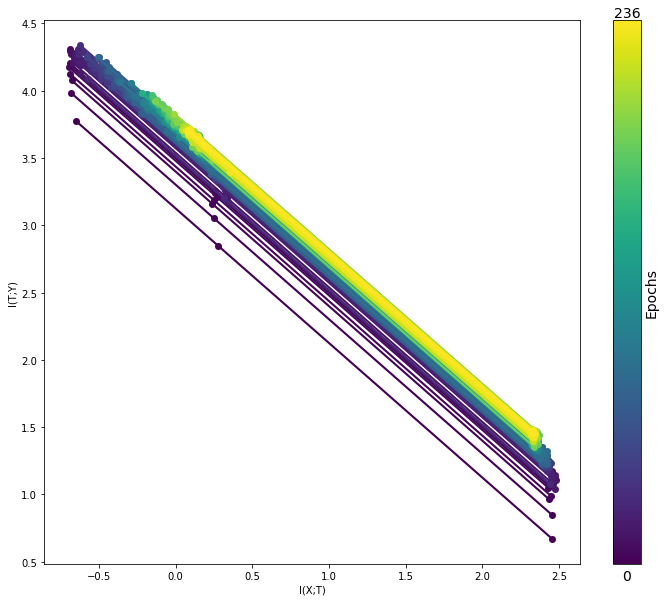

In [5]:
# %load plot.py

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


def create_color_bar(f, cmap, max_epochs, title='Epochs'):
    colorbar_axis = [0.933, 0.125, 0.03, 0.83],
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar_ax = f.add_axes(rect=colorbar_axis)
    cbar = f.colorbar(sm, ticks=[], cax=cbar_ax)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(title, size=14)
    cbar.ax.text(0.5, -0.01, '0', transform=cbar.ax.transAxes,
                 va='top', ha='center', size=14)
    cbar.ax.text(0.5, 1.0, str(max_epochs), transform=cbar.ax.transAxes,
                 va='bottom', ha='center', size=14)


def plot_info_plain(IXT, ITY):
    '''
    
    :param IXT: of shape [batch_size,layers]
    :param ITY: of shape [batch_size,layers]
    :return: 
    '''
    cmap = plt.get_cmap('viridis')
    assert len(IXT) == len(ITY)

    f = plt.figure(figsize=(12, 10))

    colors = [cmap(i) for i in np.linspace(0, 1, len(IXT))]
    for ixt, ity, color in zip(IXT, ITY, colors):
        assert len(ixt) == len(ity)
        plt.plot(ixt, ity, marker='o', ls='-', markersize=7,
                 markeredgewidth=0.04, linewidth=2.1, color=color)

    plt.xlabel("I(X;T)")
    plt.ylabel("I(T;Y)")
    create_color_bar(f, cmap, len(IXT))
    plt.show()
    plt.savefig('./fig.png')

import pickle
with open('ixt','rb') as f:
    ixt = pickle.load(f)
with open('ity','rb') as f:
    ity = pickle.load(f)
    
plot_info_plain(ixt,ity)
